In [182]:
## Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [183]:
diabetes = pd.read_csv('data/diabetes_data.csv')
display(diabetes)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Gender
0,6,98,58,33,190,34.0,0.430,43,0,Female
1,2,112,75,32,0,35.7,0.148,21,0,Female
2,2,108,64,0,0,30.8,0.158,21,0,Female
3,8,107,80,0,0,24.6,0.856,34,0,Female
4,7,136,90,0,0,29.9,0.210,50,0,Female
...,...,...,...,...,...,...,...,...,...,...
773,6,103,72,32,190,37.7,0.324,55,0,Female
774,1,71,48,18,76,20.4,0.323,22,0,Female
775,0,117,0,0,0,33.8,0.932,44,0,Female
776,4,154,72,29,126,31.3,0.338,37,0,Female


Pregnancies — количество беременностей.
Glucose — концентрация глюкозы в плазме через два часа при пероральном тесте на толерантность к глюкозе.
BloodPressure — диастолическое артериальное давление (мм рт. ст.).
SkinThickness — толщина кожной складки трицепса (мм).
Insulin — двухчасовой сывороточный инсулин (ме Ед/мл).
BMI — индекс массы тела (вес в кг / рост^2 в м).
DiabetesPedigreeFunction — функция родословной диабета (чем она выше, тем выше шанс наследственной заболеваемости).
Age — возраст.
Outcome — наличие диабета (0 — нет, 1 — да).

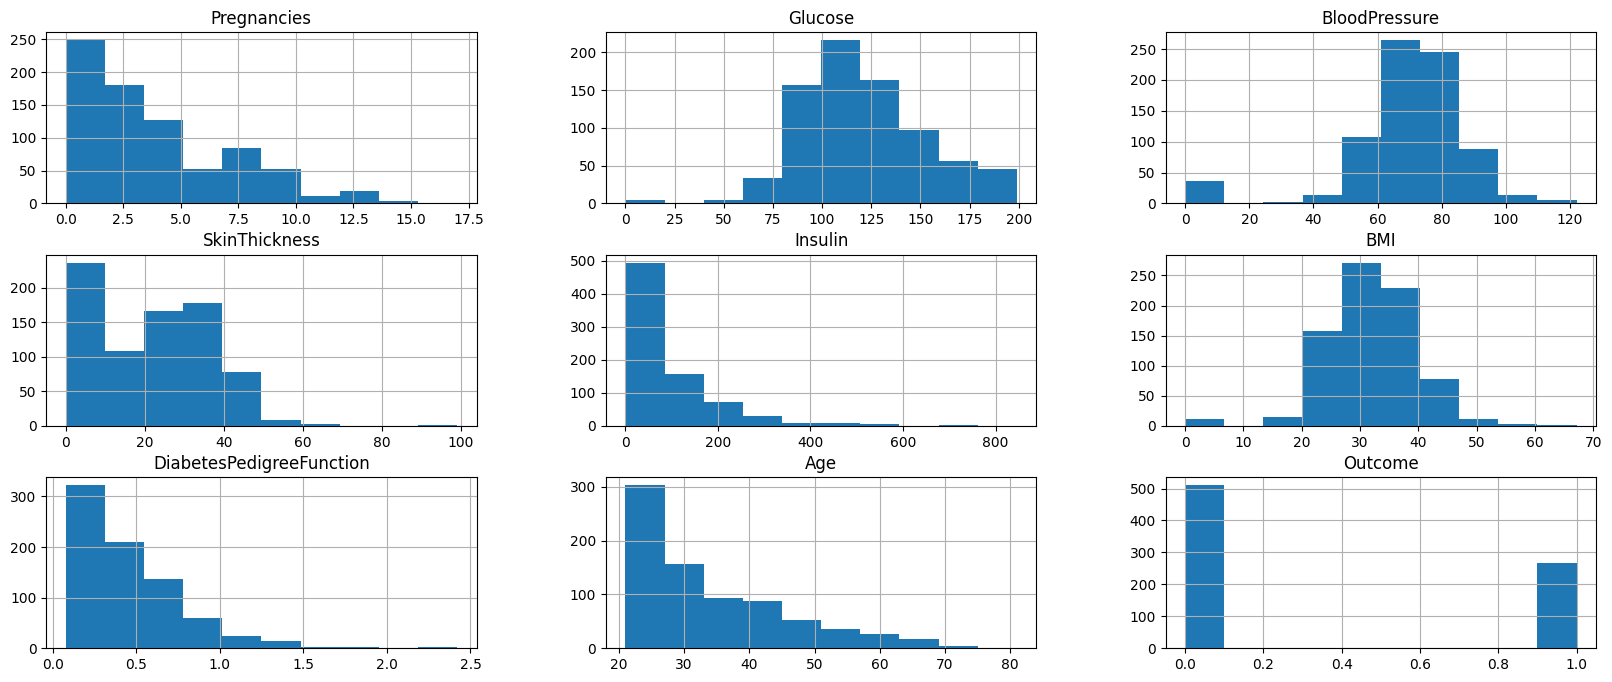

In [184]:
diabetes.hist(figsize=(20, 8));

In [185]:
mask = diabetes.duplicated()
diabetes_duplicates = diabetes[mask]
print(f'Число найденных дубликатов: {diabetes_duplicates.shape[0]}')
diabetes = diabetes.drop_duplicates(subset=diabetes_duplicates)
print(f'Результирующее число записей: {diabetes.shape[0]}')

Число найденных дубликатов: 10
Результирующее число записей: 768


In [186]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in diabetes.columns:
    #наибольшая относительная частота в признаке
    top_freq = diabetes[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = diabetes[col].nunique() / diabetes[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')
diabetes = diabetes.drop(low_information_cols, axis=1)
print(f'Результирующее число признаков: {diabetes.shape[1]}')

Gender: 100.0% одинаковых значений
Результирующее число признаков: 9


In [187]:
diabetes = diabetes.apply(
    lambda x: x.apply(
        lambda y: np.nan if (y == 0)|(y=='0') 
                        else y)
    if ((x.name != 'Outcome')and(x.name != 'Pregnancies')) else x)
cols_null_percent = diabetes.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

Insulin          48.697917
SkinThickness    29.557292
BloodPressure     4.557292
BMI               1.432292
Glucose           0.651042
dtype: float64

In [188]:
thresh = diabetes.shape[0]*0.7
#удаляем столбцы, в которых более 30% (100-70) пропусков
diabetes= diabetes.dropna(thresh=thresh, axis=1)
print(f'Результирующее число признаков: {diabetes.shape[1]}')

Результирующее число признаков: 8


In [189]:
m = diabetes.shape[1] #число признаков после удаления столбцов
diabetes = diabetes.dropna(thresh=m-2, axis=0)
print(f'Результирующее число записей: {diabetes.shape[0]}')

Результирующее число записей: 761


In [190]:
display(diabetes.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,NaN,30.8,0.158,21,0
3,8,107.0,80.0,NaN,24.6,0.856,34,0
4,7,136.0,90.0,NaN,29.9,0.210,50,0


In [191]:
values = diabetes.median()
diabetes = diabetes.fillna(values)
print(diabetes['SkinThickness'].mean().round(1))

29.1


In [192]:
## Метод межквартильного размаха
def outliers_iqr(data, feature, left=1.5, right =1.5, log_scale=False):
    x = data[feature]
    if log_scale:
        x = np.log(x)
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [193]:
outliers, cleaned = outliers_iqr(diabetes, 'SkinThickness')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 87
Результирующее число записей: 674


In [194]:
# Введите свое решение ниже
import numpy as np
def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned



In [196]:
outliers, cleaned = outliers_z_score_mod(diabetes, 'SkinThickness')
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 4
Результирующее число записей: 757


In [198]:
outliers, cleaned = outliers_iqr(diabetes, 'DiabetesPedigreeFunction')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
outliers, cleaned = outliers_iqr(diabetes, 'DiabetesPedigreeFunction',log_scale=True)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 29
Результирующее число записей: 732
Число выбросов по методу Тьюки: 0
Результирующее число записей: 761
